In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import warnings
warnings.filterwarnings('ignore')

#Data Loading and Initial Exploration

In [ ]:
# Load dataset
df = pd.read_csv('train.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


# Data Preprocessing


In [ ]:
# Convert date columns
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

# Extract time features
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Weekday'] = df['Order Date'].dt.weekday
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days

# Calculate profit and margin
margin_rates = {
    'Furniture': 0.20, 'Office Supplies': 0.30, 'Technology': 0.25,
    'Clothing': 0.30, 'Electronics': 0.15
}
df['Profit'] = df['Sales'] * df['Category'].map(margin_rates)
df['Profit Margin'] = df['Profit'] / df['Sales']

# Handle missing values
df.dropna(inplace=True)


# Feature Engineering

In [ ]:
# Encode categorical variables
cat_cols = ['Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category', 'Product Name']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Create aggregated features
region_sales = df.groupby('Region')['Sales'].mean().to_dict()
df['Region_Sales_Avg'] = df['Region'].map(region_sales)

segment_sales = df.groupby('Segment')['Sales'].mean().to_dict()
df['Segment_Sales_Avg'] = df['Segment'].map(segment_sales)

# Create price tier
df['Price_Tier'] = pd.qcut(df['Sales'], q=4, labels=[1, 2, 3, 4])

# Exploratory Data Analysis (EDA)

Monthly Sales & Profit trends


In [ ]:

# Prepare monthly data
monthly_data = df.groupby(['Order Year', 'Order Month']).agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()
monthly_data['Year-Month'] = monthly_data['Order Year'].astype(str) + '-' + monthly_data['Order Month'].astype(str)

# Create interactive plot
fig_monthly = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig_monthly.add_trace(
    go.Scatter(
        x=monthly_data['Year-Month'],
        y=monthly_data['Sales'],
        name="Sales",
        line=dict(color='blue'),
        hovertemplate="<b>%{x}</b><br>Sales: $%{y:,.0f}<extra></extra>"
    ),
    secondary_y=False
)

fig_monthly.add_trace(
    go.Scatter(
        x=monthly_data['Year-Month'],
        y=monthly_data['Profit'],
        name="Profit",
        line=dict(color='orange'),
        hovertemplate="<b>%{x}</b><br>Profit: $%{y:,.0f}<extra></extra>"
    ),
    secondary_y=True
)

# Update layout
fig_monthly.update_layout(
    title="Monthly Sales and Profit Trends",
    xaxis_title="Month",
    hovermode="x unified",
    template="plotly_white",
    height=500,
    xaxis=dict(
        tickangle=45,
        rangeslider=dict(visible=True)
    )
)

fig_monthly.update_yaxes(title_text="<b>Sales</b> ($)", secondary_y=False)
fig_monthly.update_yaxes(title_text="<b>Profit</b> ($)", secondary_y=True)

fig_monthly.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Prepare the time series data
time_series = df.set_index('Order Date')['Sales'].resample('D').sum().ffill()

# Perform decomposition
decomposition = seasonal_decompose(time_series, model='additive')

# Create interactive plot with subplots
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.3,
    subplot_titles=("Observed", "Trend", "Residual")
)

# Add traces for each component
fig.add_trace(
    go.Scatter(
        x=decomposition.observed.index,
        y=decomposition.observed,
        name='Observed',
        line=dict(color='#1f77b4'),
        hovertemplate='Date: %{x|%b %d, %Y}<br>Sales: $%{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=decomposition.trend.index,
        y=decomposition.trend,
        name='Trend',
        line=dict(color='#ff7f0e', width=2),
        hovertemplate='Date: %{x|%b %d, %Y}<br>Trend: $%{y:,.0f}<extra></extra>'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=decomposition.resid.index,
        y=decomposition.resid,
        name='Residual',
        line=dict(color='#d62728'),
        hovertemplate='Date: %{x|%b %d, %Y}<br>Residual: $%{y:,.0f}<extra></extra>'
    ),
    row=3, col=1
)

# Update layout
fig.update_layout(
    title='<b>Interactive Time Series Decomposition of Sales</b>',
    title_font_size=20,
    title_x=0.5,
    height=800,
    template='plotly_white',
    hovermode='x unified',
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50),
)

# Add range slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Format y-axis labels
fig.update_yaxes(tickprefix="$", tickformat=",")

# Add annotation
fig.add_annotation(
    x=0.5, y=-0.15,
    xref='paper', yref='paper',
    text="<i>Additive decomposition of daily sales data</i>",
    showarrow=False,
    font=dict(size=10, color="grey")
)

fig.show()

Average Profit Margin by Product Category

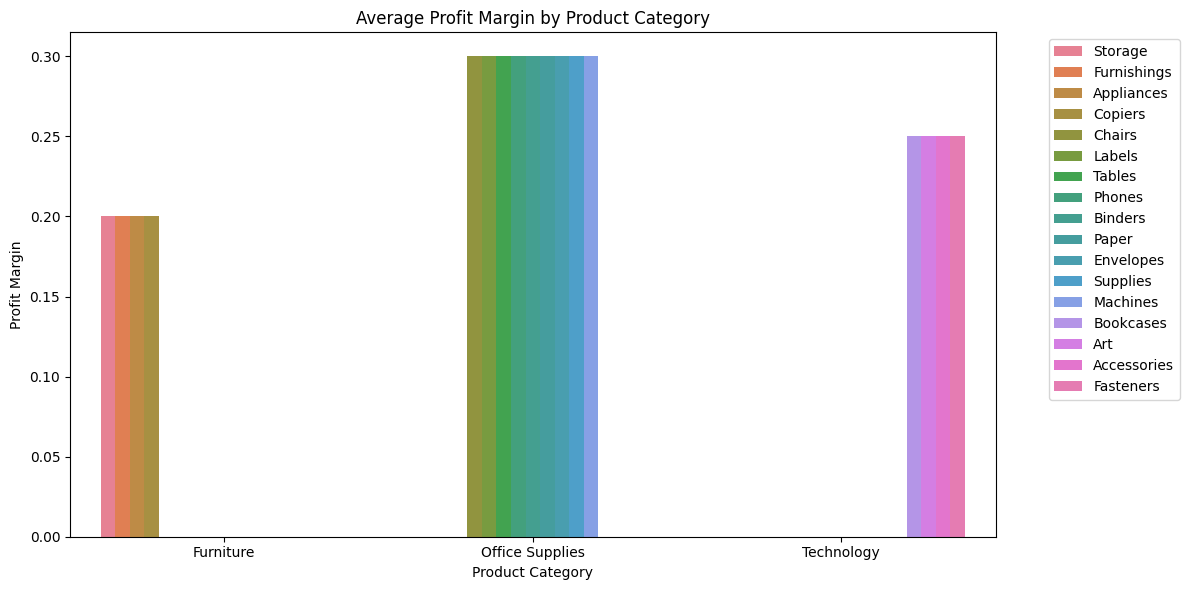

In [ ]:

# Prepare category data
category_profit = df.groupby(['Category', 'Sub-Category']).agg({'Profit Margin': 'mean'}).reset_index()

# Map encoded values to original names
category_map = {0: 'Furniture', 1: 'Office Supplies', 2: 'Technology'}
subcategory_map = {
    0: 'Bookcases', 1: 'Chairs', 2: 'Labels', 3: 'Tables',
    4: 'Storage', 5: 'Furnishings', 6: 'Art', 7: 'Phones',
    8: 'Binders', 9: 'Appliances', 10: 'Paper', 11: 'Accessories',
    12: 'Envelopes', 13: 'Fasteners', 14: 'Supplies', 15: 'Machines',
    16: 'Copiers'
}

category_profit['Category'] = category_profit['Category'].map(category_map)
category_profit['Sub-Category'] = category_profit['Sub-Category'].map(subcategory_map)

# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(data=category_profit, x='Category', y='Profit Margin', hue='Sub-Category')
plt.title('Average Profit Margin by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Profit Margin')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

SalesS VS Profit by REGION

In [ ]:
# Prepare region data
profit_by_region = df.groupby('Region')['Profit'].sum()
sales_by_region = df.groupby('Region')['Sales'].sum()

# Create interactive plot
fig_region = go.Figure()

# Add bars
fig_region.add_trace(go.Bar(
    x=profit_by_region.index,
    y=sales_by_region.values,
    name='Sales',
    marker_color='#1f77b4',
    hovertemplate='<b>%{x}</b><br>Sales: $%{y:,.0f}<extra></extra>'
))

fig_region.add_trace(go.Bar(
    x=profit_by_region.index,
    y=profit_by_region.values,
    name='Profit',
    marker_color='#ff7f0e',
    hovertemplate='<b>%{x}</b><br>Profit: $%{y:,.0f}<extra></extra>'
))

# Update layout
fig_region.update_layout(
    title=dict(
        text='Sales vs Profit by Region',
        x=0.5,  # Center the title
        xanchor='center'
    ),
    xaxis_title='Region',
    yaxis_title='Amount ($)',
    barmode='group',
    hovermode='x unified',
    template='plotly_white',
    height=500,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=50, r=50, t=80, b=50),
    xaxis=dict(
        tickmode='array',
        tickvals=profit_by_region.index,
        ticktext=['South', 'West', 'East', 'Central']  # Ensure these match your actual region names
    )
)

# Add margin annotations
for region in profit_by_region.index:
    fig_region.add_annotation(
        x=region,
        y=max(sales_by_region[region], profit_by_region[region]) * 1.05,
        text=f"Margin: {(profit_by_region[region]/sales_by_region[region]*100):.1f}%",
        showarrow=False,
        font=dict(size=10)
    )

# Add view toggle
fig_region.update_layout(
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=0.2, y=1.15,
        buttons=[
            dict(label="Both", method="update",
                 args=[{"visible": [True, True]}, {"title": "Sales vs Profit by Region"}]),
            dict(label="Sales Only", method="update",
                 args=[{"visible": [True, False]}, {"title": "Sales by Region"}]),
            dict(label="Profit Only", method="update",
                 args=[{"visible": [False, True]}, {"title": "Profit by Region"}])
        ]
    )]
)

fig_region.show()

 # Model Building and Evaluation

In [ ]:
X = df.drop(['Sales', 'Order Date', 'Ship Date', 'Row ID', 'Customer ID',
             'Customer Name', 'Product ID', 'Order ID', 'Postal Code'], axis=1)
y = df['Sales']

# Encode and scale
X_encoded = X.copy()
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Neural Network
nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')

# Evaluate models
results = []
for name, model in models.items():
    results.append({'Model': name, **evaluate_model(model, X_train, X_test, y_train, y_test)})

# Evaluate NN separately
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
y_pred_nn = nn_model.predict(X_test).flatten()
results.append({
    'Model': 'Neural Network',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'MAE': mean_absolute_error(y_test, y_pred_nn)
})
# Display results
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
display(results_df)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Performance Comparison:


,Model,RMSE,R2,MAE
0,Linear Regression,79.157870,0.987190,34.212622
1,Random Forest,176.850509,0.936058,12.119564
2,XGBoost,423.130593,0.633966,36.315963
3,Neural Network,77.039113,0.987866,48.685930


# Feature Importance and SHAP Analysis

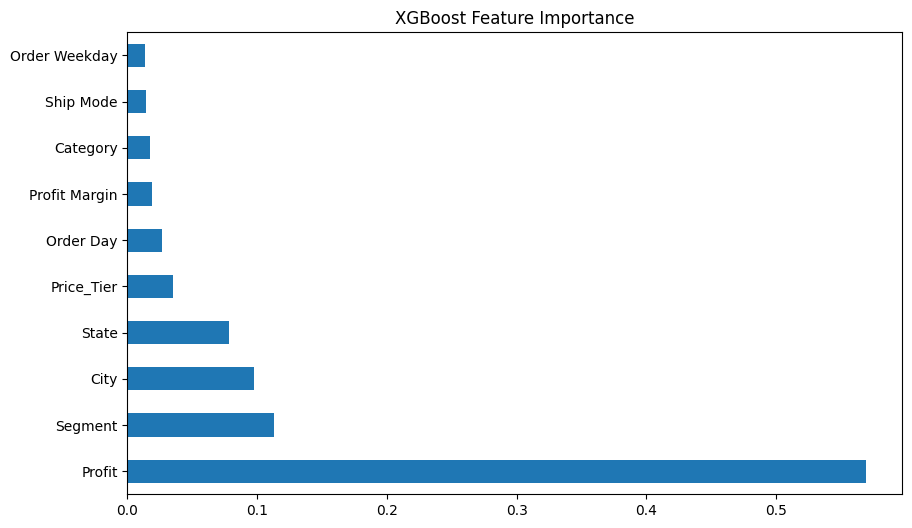

In [ ]:
# XGBoost feature importance
xgb = models['XGBoost']
xgb.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
pd.Series(xgb.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()

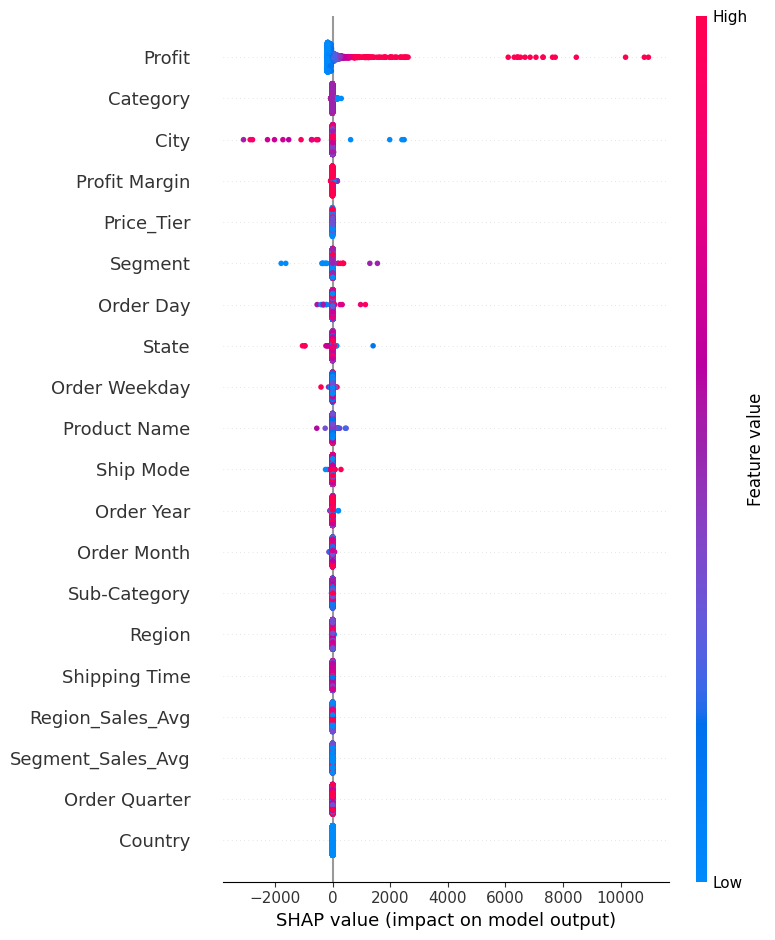

In [ ]:
# SHAP values
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)